In [2]:
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates

In [3]:
# Load statement data
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv')

# Convert billing_cycle_date to datetime
df_statements['billing_cycle_date'] = pd.to_datetime(df_statements['billing_cycle_date'], utc=True)

# Load account data
df_accounts = pd.read_csv('cleaned_data/cleaned_account_dim.csv')

# Merge datasets to include income classification
df_merged = df_statements.merge(
    df_accounts[['current_account_nbr', 'is_high_income']], 
    on='current_account_nbr', 
    how='left'
)

# Ensure billing_cycle_date is in datetime format
df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)

# Adjust billing_cycle_date to the 15th of the month
df_merged['billing_cycle_date_15th'] = df_merged['billing_cycle_date'].apply(lambda x: x.replace(day=15))
df_merged.set_index('billing_cycle_date_15th', inplace=True)

# Split dataset based on income classification
df_high_income = df_merged[df_merged['is_high_income'] == 1]
df_non_high_income = df_merged[df_merged['is_high_income'] == 0]

# Aggregate previous balance by billing cycle for both groups
df_high_income_avg_balance = df_high_income.groupby('billing_cycle_date_15th')['prev_balance'].mean()
df_non_high_income_avg_balance = df_non_high_income.groupby('billing_cycle_date_15th')['prev_balance'].mean()

/var/folders/c0/ffxpm1sd2nn95pxfz923sdn40000gp/T/ipykernel_89204/3682154063.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spending["year_month"] = df_spending["transaction_date"].dt.to_period("M")


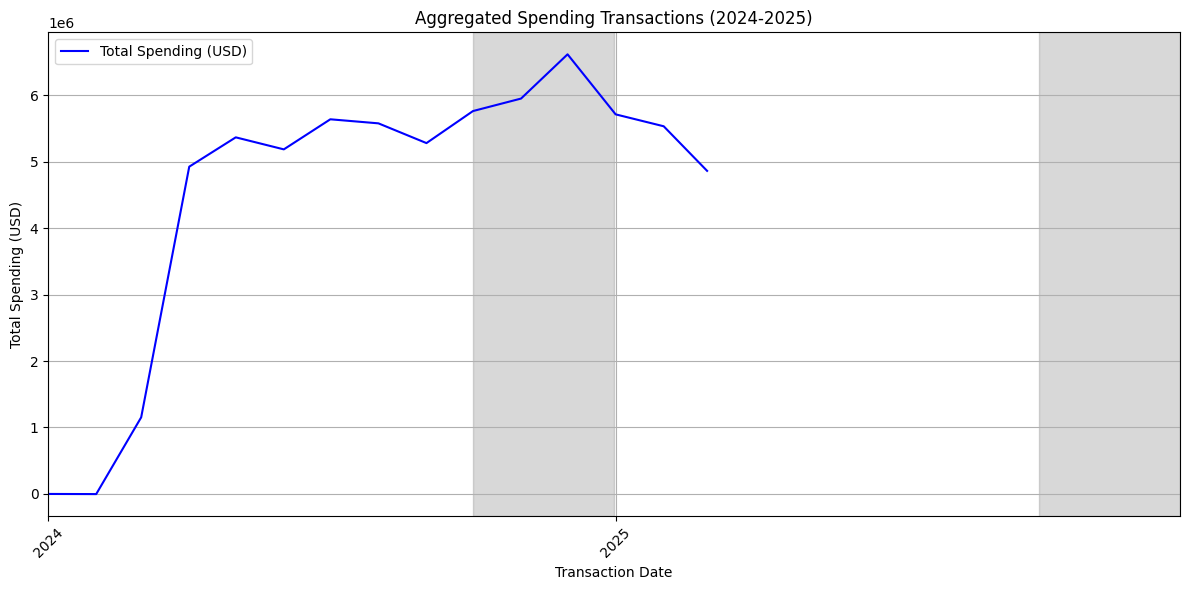

In [4]:
# Load transaction datasets
df_transactions = pd.read_csv("cleaned_data/cleaned_transaction_fact.csv", parse_dates=["transaction_date"])
df_world_transactions = pd.read_csv("cleaned_data/cleaned_wrld_stor_tran_fact.csv", parse_dates=["transaction_date"])

# Combine both datasets
df = pd.concat([df_transactions, df_world_transactions])

# Filter for spending transactions (assuming "SALE" represents spending)
df_spending = df[df["transaction_type"] == "SALE"]

# Aggregate spending amounts by month
df_spending["year_month"] = df_spending["transaction_date"].dt.to_period("M")
df_monthly_spending = df_spending.groupby("year_month")["us_equiv_amt"].sum().reset_index()
df_monthly_spending["year_month"] = df_monthly_spending["year_month"].dt.to_timestamp()

# Filter for transactions within 2024 and 2025
df_monthly_spending = df_monthly_spending[
    (df_monthly_spending["year_month"].dt.year >= 2024) & 
    (df_monthly_spending["year_month"].dt.year <= 2025)
]

# Plot spending trend
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_monthly_spending["year_month"], df_monthly_spending["us_equiv_amt"], 
        label="Total Spending (USD)", color="blue")

# Format x-axis to display only 2024 and 2025
ax.set_xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2025-12-31"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Highlight the last three months of each year
for year in [2024, 2025]:
    ax.axvspan(pd.Timestamp(f"{year}-10-01"), pd.Timestamp(f"{year}-12-31"), color='grey', alpha=0.3)

# Labels and title
ax.set_xlabel("Transaction Date")
ax.set_ylabel("Total Spending (USD)")
ax.set_title("Aggregated Spending Transactions (2024-2025)")

# Formatting and saving
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./visualizations/spending_trend_2024_2025.png', dpi=300)
plt.show()

In [5]:
# Load transaction data and filter for "SPEND" transactions
df_transactions = pd.read_csv('cleaned_data/cleaned_transaction_fact.csv', parse_dates=['transaction_date'])
df_spending = df_transactions[df_transactions["transaction_type"] == "SPEND"]

# Load account statements and convert date column
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv', parse_dates=['billing_cycle_date'])

# Load account data and merge with statements
df_accounts = pd.read_csv('cleaned_data/cleaned_account_dim.csv')
df_merged = df_statements.merge(df_accounts[['current_account_nbr', 'is_high_income']], 
                                on='current_account_nbr', how='left')

# Ensure billing cycle date is in datetime format
df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)

# Normalize billing cycle dates to the 15th of each month
df_merged['billing_cycle_date_15th'] = df_merged['billing_cycle_date'].apply(lambda x: x.replace(day=15))
df_merged.set_index('billing_cycle_date_15th', inplace=True)

# Split dataset based on income classification
df_high_income = df_merged[df_merged['is_high_income'] == 1]
df_non_high_income = df_merged[df_merged['is_high_income'] == 0]

# Aggregate previous balance by billing cycle for both groups
df_high_income_avg_balance = df_high_income.groupby('billing_cycle_date_15th')['prev_balance'].mean()
df_non_high_income_avg_balance = df_non_high_income.groupby('billing_cycle_date_15th')['prev_balance'].mean()

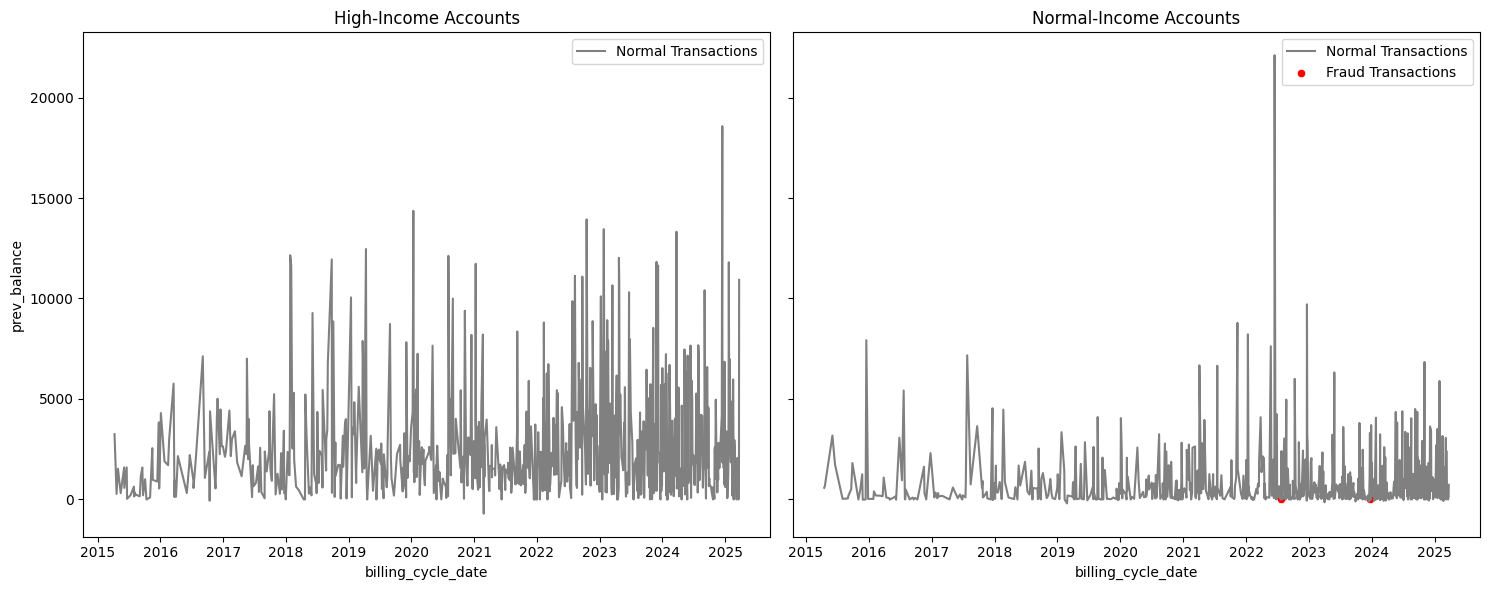

In [9]:
# Load datasets
df_fraud = pd.read_csv('exploratory_data_analysis/master_user_dataset_with_predictions.csv')
df_syf = pd.read_csv('cleaned_data/cleaned_syf_id.csv')
df_statements = pd.read_csv('cleaned_data/cleaned_statement_fact.csv')
df_high_income = pd.read_csv('cleaned_data/cleaned_account_dim.csv')

# Merge dataframes
df_merged = df_statements.merge(df_high_income[['current_account_nbr', 'is_high_income']], on='current_account_nbr', how='left')
df_merged = df_merged.merge(df_syf[['account_nbr_pty', 'ds_id']], left_on='current_account_nbr', right_on='account_nbr_pty', how='left')
df_merged.rename(columns={'ds_id': 'user_id'}, inplace=True)
df_merged = df_merged.merge(df_fraud[['user_id', 'has_fraud']], on='user_id', how='left')

# Convert 'billing_cycle_date' to datetime and clean up unnecessary columns
df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)
df_merged.drop(columns=['account_nbr_pty'], inplace=True)

# Sample 1000 entries from each group based on income classification
df_high_sample = df_merged[df_merged['is_high_income'] == 1].sample(1000, random_state=42)
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0].sample(1000, random_state=42)

# Group data by 'billing_cycle_date' to calculate mean previous balance and detect fraud
df_high_grouped = df_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean', 'has_fraud': 'max'}).reset_index()
df_non_high_grouped = df_non_high_sample.groupby('billing_cycle_date').agg({'prev_balance': 'mean', 'has_fraud': 'max'}).reset_index()

# Filter for fraud transactions in both groups
df_high_fraud = df_high_grouped[df_high_grouped['has_fraud'] == 1]
df_non_high_fraud = df_non_high_grouped[df_non_high_grouped['has_fraud'] == 1]

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# High-income group plot
sns.lineplot(data=df_high_grouped, x='billing_cycle_date', y='prev_balance', ax=ax[0], color='grey', label="Normal Transactions")
if not df_high_fraud.empty:
    sns.scatterplot(data=df_high_fraud, x='billing_cycle_date', y='prev_balance', ax=ax[0], color='red', label="Fraud Transactions")
ax[0].set_title("High-Income Accounts")

# Normal-income group plot
sns.lineplot(data=df_non_high_grouped, x='billing_cycle_date', y='prev_balance', ax=ax[1], color='grey', label="Normal Transactions")
if not df_non_high_fraud.empty:
    sns.scatterplot(data=df_non_high_fraud, x='billing_cycle_date', y='prev_balance', ax=ax[1], color='red', label="Fraud Transactions")
ax[1].set_title("Normal-Income Accounts")

# Final adjustments and visualization
plt.tight_layout()
plt.show()

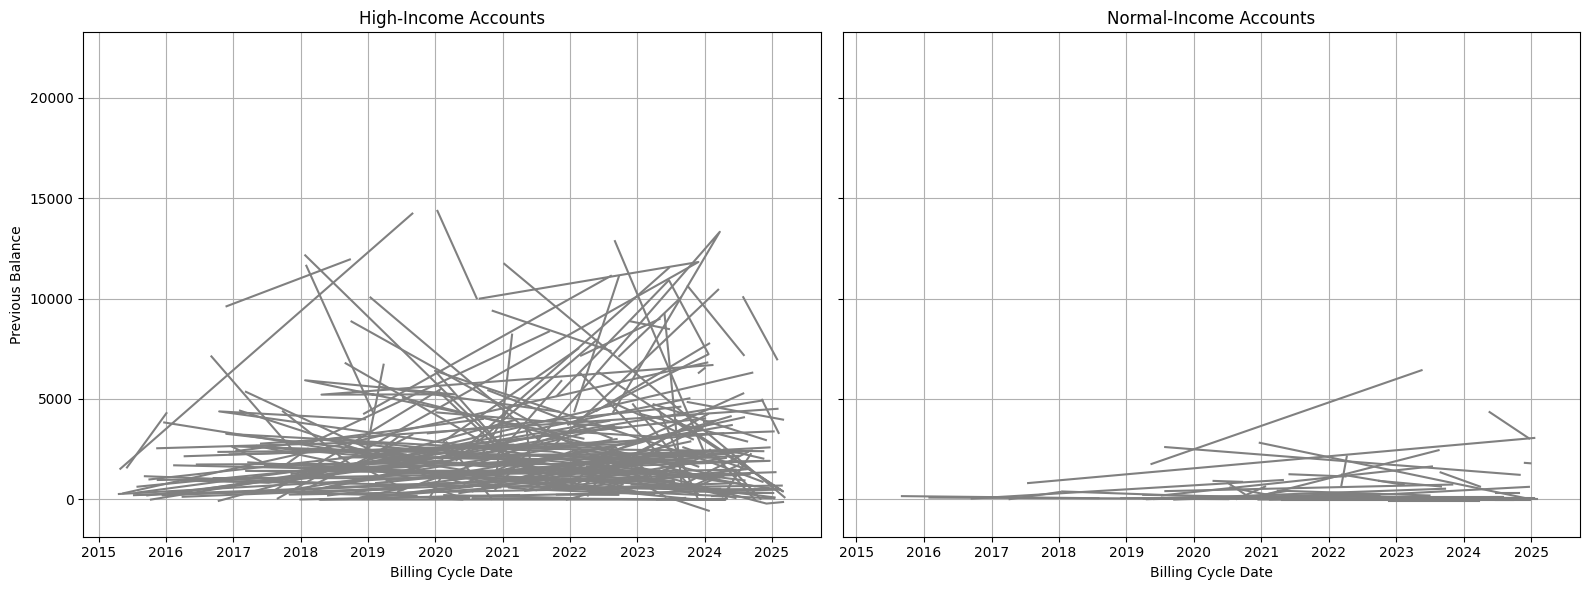

In [ ]:
# Convert billing cycle date to datetime
df_merged['billing_cycle_date'] = pd.to_datetime(df_merged['billing_cycle_date'], utc=True)

# Sample 1000 entries from high-income and normal-income groups
df_high_sample = df_merged[df_merged['is_high_income'] == 1].sample(1000, random_state=42)
df_non_high_sample = df_merged[df_merged['is_high_income'] == 0].sample(1000, random_state=42)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Function to plot account balances
def plot_account_balance(ax, df_sample, title):
    ax.set_title(title)
    ax.set_xlabel("Billing Cycle Date")
    ax.set_ylabel("Previous Balance")
    
    # Loop through each account and plot its data
    for account in df_sample['current_account_nbr'].unique():
        account_data = df_sample[df_sample['current_account_nbr'] == account]
        color = 'red' if account_data['has_fraud'].max() == 1 else 'grey'
        ax.plot(account_data['billing_cycle_date'], account_data['prev_balance'], color=color)
    
    ax.grid(True)

# Plot for High-Income Accounts
plot_account_balance(axes[0], df_high_sample, "High-Income Accounts")

# Plot for Normal-Income Accounts
plot_account_balance(axes[1], df_non_high_sample, "Normal-Income Accounts")

# Adjust layout
plt.tight_layout()
plt.show()

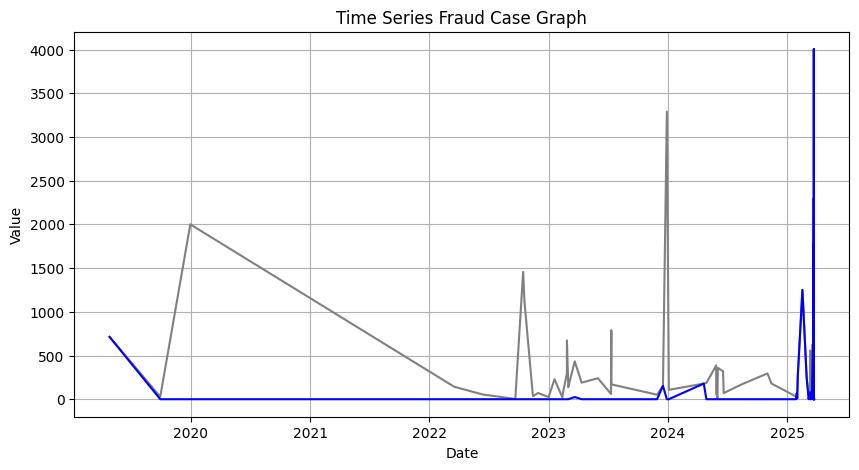

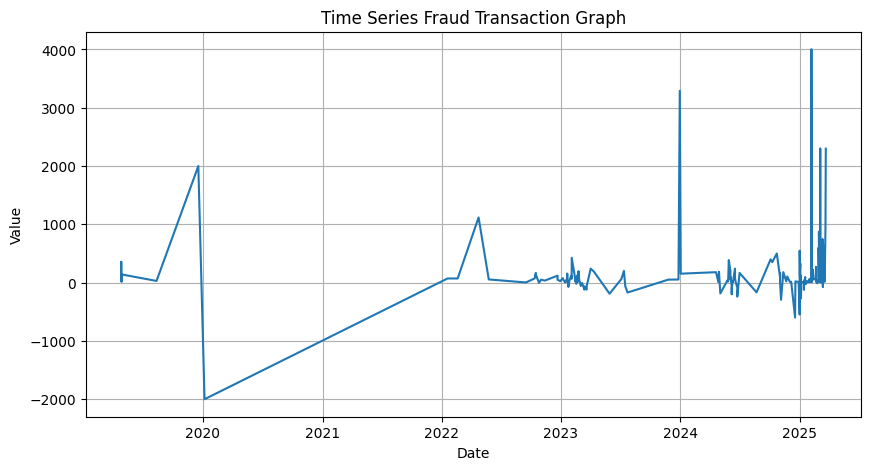

In [8]:
# Size of fraud cases through time series 
df_case = pd.read_csv('cleaned_data/cleaned_fraud_claim.csv')
cols_to_replace = ['reported_date', 'open_date', 'reopen_date', 'close_date']
for col in cols_to_replace:
    df_case[col] = pd.to_datetime(df_case[col], utc=True)

df_case = df_case.sort_values("reported_date", ascending=True)

df_case.dtypes
plt.figure(figsize=(10,5))

# plotting gross fraud & net fraud amount
plt.plot(df_case['reported_date'], df_case['gross_fraud_amt'], label='Gross Fraud Amount', color='grey')
plt.plot(df_case['reported_date'], df_case['net_fraud_amt'], label='Net Fraud Amount', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Fraud Case Graph')
plt.grid(True)
plt.show()

# Size of fraud transactions through time series 
df_tran = pd.read_csv('cleaned_data/cleaned_fraud_tran.csv')
cols_to_replace = ['transaction_dt']
for col in cols_to_replace:
    df_tran[col] = pd.to_datetime(df_tran[col], utc=True)

df_tran = df_tran.sort_values('transaction_dt', ascending=True)

df_tran.dtypes
plt.figure(figsize=(10,5))
plt.plot(df_tran['transaction_dt'], df_tran['transaction_am']) 
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Fraud Transaction Graph')
plt.grid(True)
plt.show()